<a href="https://colab.research.google.com/github/szuhow/keyframe-selector/blob/main/Untitled18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
from scipy import ndimage
from skimage import morphology, measure, draw
import matplotlib.pyplot as plt
import cv2
import os
import re

class CoronaryKeyframeSelector:
    def __init__(self, masks):
        """
        masks: lista masek binarnych (numpy arrays) z kolejnych klatek
        """
        self.masks = np.array(masks)
        self.n_frames = len(masks)

    def compute_overlap_mask(self, threshold=0.3):
        """
        Tworzy maskę overlapping regions - odrzuca obszary występujące
        tylko w pojedynczych klatkach (prawdopodobne artefakty)
        """
        # Normalizuj do [0,1] i uśrednij
        mean_mask = np.mean(self.masks.astype(float), axis=0)

        # Zachowaj tylko regiony występujące w >threshold klatek
        overlap_mask = (mean_mask > threshold).astype(np.uint8)
        return overlap_mask

    def compute_frame_scores(self):
        """
        Oblicza multi-criteria score dla każdej klatki
        """
        overlap_mask = self.compute_overlap_mask()
        scores = []

        for i, mask in enumerate(self.masks):
            # Filtruj maskę przez overlap_mask
            filtered_mask = mask & overlap_mask

            # Kryterium 1: Powierzchnia naczyń
            vessel_area = np.sum(filtered_mask)

            # Kryterium 2: Spójność (mniej komponenty = lepiej)
            labeled, n_components = ndimage.label(filtered_mask)

            # Kryterium 3: Topologia - wypełnienie dziur
            filled = ndimage.binary_fill_holes(filtered_mask)
            holes_area = np.sum(filled) - vessel_area

            # Kryterium 4: Kompaktowość (vessel_area / convex_hull_area)
            if vessel_area > 0:
                hull = morphology.convex_hull_image(filtered_mask)
                compactness = vessel_area / (np.sum(hull) + 1e-6)
            else:
                compactness = 0

            # Kryterium 5: Długość szkieletu (im dłuższy tym lepiej)
            skeleton = morphology.skeletonize(filtered_mask)
            skeleton_length = np.sum(skeleton)

            # Kryterium 6-8: Grubość naczyń (BARDZO ISTOTNE!)
            # Distance transform - odległość każdego piksela od krawędzi
            distance_map = ndimage.distance_transform_edt(filtered_mask)

            # Max thickness - najgrubszy punkt naczynia
            max_vessel_thickness = np.max(distance_map) * 2 if vessel_area > 0 else 0

            # Mean thickness - średnia grubość wszystkich pikseli naczyń
            mean_vessel_thickness = np.mean(distance_map[distance_map > 0]) * 2 if np.any(distance_map > 0) else 0

            # Skeleton thickness - grubość wzdłuż osi naczynia (najbardziej reprezentatywne)
            if skeleton_length > 0:
                skeleton_thickness = np.sum(distance_map[skeleton > 0]) / skeleton_length * 2
            else:
                skeleton_thickness = 0

            # NOWE: Kryterium 9 - Aspect ratio (elongation)
            # Preferuje wydłużone struktury (naczynia) nad okrągłe (artefakty)
            if vessel_area > 0:
                props = measure.regionprops((filtered_mask > 0).astype(int))[0]
                aspect_ratio = props.major_axis_length / (props.minor_axis_length + 1e-6)
            else:
                aspect_ratio = 0

            # NOWE: Kryterium 10 - Coverage ratio with penalty for small vessels
            # Stosunek długości szkieletu do powierzchni - preferuje długie cienkie struktury
            # ALE z karą dla bardzo małych naczyń (aby uniknąć preferowania artefaktów)
            if vessel_area > 0 and skeleton_length > 0:
                base_coverage = skeleton_length / (vessel_area + 1e-6)
                # Kara dla małych naczyń: im większe naczynie, tym mniejsza kara
                # Normalizuj vessel_area względem maksymalnej oczekiwanej wartości
                size_factor = min(vessel_area / 1000.0, 1.0)  # 1000 pikseli jako punkt odniesienia
                coverage_ratio = base_coverage * size_factor
            else:
                coverage_ratio = 0

            scores.append({
                'frame_idx': i,
                'vessel_area': vessel_area,
                'n_components': n_components,
                'holes_area': holes_area,
                'compactness': compactness,
                'skeleton_length': skeleton_length,
                'max_thickness': max_vessel_thickness,
                'mean_thickness': mean_vessel_thickness,
                'skeleton_thickness': skeleton_thickness,
                'aspect_ratio': aspect_ratio,
                'coverage_ratio': coverage_ratio
            })

        return scores

    def select_best_frame(self, weights=None, profile='balanced'):
        """
        Wybiera najlepszą klatkę na podstawie ważonej sumy kryteriów
        
        Parameters:
        -----------
        weights : dict, optional
            Własne wagi dla każdego kryterium
        profile : str, default='balanced'
            Predefiniowany profil wag: 'balanced', 'long_vessels', 'thick_vessels', 'complete_tree'
        """
        if weights is None:
            # Predefiniowane profile wag
            weight_profiles = {
                'balanced': {
                    'vessel_area': 0.30,           # Zwiększone z 0.25
                    'n_components': -0.15,
                    'holes_area': -0.10,
                    'compactness': 0.05,           # Zmniejszone z 0.10
                    'skeleton_length': 0.30,       # Zwiększone z 0.15
                    'max_thickness': 0.05,         # Zmniejszone z 0.15
                    'mean_thickness': 0.05,        # Zmniejszone z 0.10
                    'skeleton_thickness': 0.10,    # Zmniejszone z 0.20
                    'aspect_ratio': 0.10,          # NOWE
                    'coverage_ratio': 0.10         # NOWE
                },
                'long_vessels': {
                    'vessel_area': 0.25,
                    'n_components': -0.10,
                    'holes_area': -0.05,
                    'compactness': 0.05,
                    'skeleton_length': 0.45,       # Maksymalny priorytet dla długości
                    'max_thickness': 0.05,
                    'mean_thickness': 0.05,
                    'skeleton_thickness': 0.05,
                    'aspect_ratio': 0.15,          # Wysoki priorytet dla elongacji
                    'coverage_ratio': 0.15         # Wysoki priorytet dla coverage
                },
                'thick_vessels': {
                    'vessel_area': 0.20,
                    'n_components': -0.10,
                    'holes_area': -0.05,
                    'compactness': 0.05,
                    'skeleton_length': 0.15,
                    'max_thickness': 0.20,
                    'mean_thickness': 0.15,
                    'skeleton_thickness': 0.30,    # Priorytet dla grubości
                    'aspect_ratio': 0.05,
                    'coverage_ratio': 0.05
                },
                'complete_tree': {
                    'vessel_area': 0.35,           # Wysoki priorytet dla obszaru
                    'n_components': -0.20,         # Silna kara za fragmentację
                    'holes_area': -0.15,           # Silna kara za dziury
                    'compactness': 0.10,
                    'skeleton_length': 0.35,       # Wysoki priorytet dla długości
                    'max_thickness': 0.05,
                    'mean_thickness': 0.05,
                    'skeleton_thickness': 0.05,
                    'aspect_ratio': 0.05,
                    'coverage_ratio': 0.05
                }
            }
            
            weights = weight_profiles.get(profile, weight_profiles['balanced'])

        scores = self.compute_frame_scores()

        # Normalizuj każde kryterium do [0,1]
        metrics = {k: [s[k] for s in scores] for k in scores[0].keys() if k != 'frame_idx'}

        normalized_scores = []
        for score in scores:
            norm_score = 0
            for metric, weight in weights.items():
                if metric not in metrics:
                    continue

                values = metrics[metric]
                min_val, max_val = min(values), max(values)

                if max_val > min_val:
                    norm_value = (score[metric] - min_val) / (max_val - min_val)
                else:
                    norm_value = 0

                norm_score += weight * norm_value

            normalized_scores.append(norm_score)

        best_idx = np.argmax(normalized_scores)

        return {
            'best_frame_idx': best_idx,
            'score': normalized_scores[best_idx],
            'all_scores': scores,
            'normalized_scores': normalized_scores,
            'weights_used': weights
        }

    def visualize_selection(self, result):
        """
        Pomocnicza funkcja do wizualizacji wyników
        """
        best_idx = result['best_frame_idx']
        print(f"Wybrana klatka: {best_idx}")
        print(f"Score: {result['score']:.3f}")
        print(f"\nMetryki wybranej klatki:")
        for k, v in result['all_scores'][best_idx].items():
            if k != 'frame_idx':
                print(f"  {k}: {v:.2f}")
        
        print(f"\nUżyte wagi:")
        for k, v in result['weights_used'].items():
            print(f"  {k}: {v:.2f}")


def generate_synthetic_coronary_masks(n_frames=20, img_size=(256, 256)):
    """
    Generuje syntetyczne maski naczyń wieńcowych dla testowania
    """
    masks = []

    # Główne drzewo naczyniowe (stabilne)
    main_tree_center = (img_size[0] // 2, img_size[1] // 2)

    for i in range(n_frames):
        mask = np.zeros(img_size, dtype=np.uint8)

        # Fazowanie serca - symuluje ruch naczyń
        phase = i / n_frames * 2 * np.pi
        offset_x = int(10 * np.sin(phase))
        offset_y = int(10 * np.cos(phase))

        # Główne naczynie - pień
        trunk_start = (main_tree_center[0] + offset_x, main_tree_center[1] + offset_y)
        trunk_end = (trunk_start[0] + 80, trunk_start[1] + 20)
        rr, cc = draw.line(trunk_start[0], trunk_start[1], trunk_end[0], trunk_end[1])
        # Pogrub naczynie
        for r, c in zip(rr, cc):
            cv2.circle(mask, (c, r), 4, 1, -1)

        # Gałęzie boczne
        # Gałąź 1
        branch1_start = (trunk_start[0] + 30, trunk_start[1] + 10)
        branch1_end = (branch1_start[0] + 40, branch1_start[1] - 50)
        rr, cc = draw.line(branch1_start[0], branch1_start[1], branch1_end[0], branch1_end[1])
        for r, c in zip(rr, cc):
            cv2.circle(mask, (c, r), 3, 1, -1)

        # Gałąź 2
        branch2_start = (trunk_start[0] + 50, trunk_start[1] + 15)
        branch2_end = (branch2_start[0] + 30, branch2_start[1] + 60)
        rr, cc = draw.line(branch2_start[0], branch2_start[1], branch2_end[0], branch2_end[1])
        for r, c in zip(rr, cc):
            cv2.circle(mask, (c, r), 3, 1, -1)

        # Symuluj różną widoczność naczyń w różnych fazach
        # W fazach 0.3-0.7 naczynia są najbardziej widoczne (najlepsza faza)
        visibility = 1.0 - 0.5 * abs(np.sin(phase - np.pi/2))

        if visibility < 0.6:
            # W złych fazach: dodaj disconnected fragments
            # Artefakt 1
            if i % 4 == 0:
                cv2.circle(mask, (50, 50), 8, 1, -1)
            # Artefakt 2
            if i % 3 == 0:
                cv2.circle(mask, (200, 200), 6, 1, -1)

        # W środkowych klatkach (najlepsza faza) dodaj więcej szczegółów
        if 6 <= i <= 14:
            # Małe gałązki końcowe
            subbranch_start = (branch1_end[0] + 10, branch1_end[1] - 5)
            subbranch_end = (subbranch_start[0] + 15, subbranch_start[1] - 20)
            rr, cc = draw.line(subbranch_start[0], subbranch_start[1],
                              subbranch_end[0], subbranch_end[1])
            for r, c in zip(rr, cc):
                cv2.circle(mask, (c, r), 2, 1, -1)

        # Dodaj szum
        noise = np.random.random(img_size) > 0.98
        mask = np.logical_or(mask, noise).astype(np.uint8)

        masks.append(mask)

    return masks


def visualize_comprehensive_results(masks, selector, result, output_dir='keyframe_analysis'):
    """
    Kompleksowa wizualizacja wyników - generuje osobne pliki dla każdej klatki
    """
    best_idx = result['best_frame_idx']
    scores = result['all_scores']
    normalized_scores = result['normalized_scores']
    n_frames = len(masks)
    
    # Stwórz folder wyjściowy
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"✓ Utworzono folder: {output_dir}")
    
    # Metryki do wizualizacji
    metric_names = ['vessel_area', 'skeleton_length', 'n_components', 'holes_area', 
                   'compactness', 'max_thickness', 'mean_thickness', 'skeleton_thickness',
                   'aspect_ratio', 'coverage_ratio']
    
    # Kolory dla metryk
    metric_colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', 
                    '#9b59b6', '#1abc9c', '#34495e', '#16a085',
                    '#d35400', '#c0392b']
    
    # Normalizuj wszystkie metryki do [0,1] dla lepszej wizualizacji
    normalized_metrics = {}
    for metric in metric_names:
        values = [s[metric] for s in scores]
        min_val, max_val = min(values), max(values)
        if max_val > min_val:
            normalized_metrics[metric] = [(v - min_val) / (max_val - min_val) for v in values]
        else:
            normalized_metrics[metric] = [0] * len(values)
    
    print(f"\n Generowanie {n_frames} wizualizacji...")
    
    # Generuj osobny plik dla każdej klatki
    for i in range(n_frames):
        # Stwórz figurę dla pojedynczej klatki
        fig = plt.figure(figsize=(16, 8))
        # Dodaj więcej miejsca na górze dla tytułu
        gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[1, 2, 1],
                             hspace=0.4, wspace=0.4, top=0.92, bottom=0.08, left=0.05, right=0.98)
        
        # 1. Obraz maski - zachowaj aspect ratio
        ax_img = fig.add_subplot(gs[:, 0])
        ax_img.imshow(masks[i], cmap='gray', aspect='equal')  # aspect='equal' zachowuje proporcje
        ax_img.axis('off')  # Wyłącz wszystkie elementy osi
        
        # Obramowanie dla najlepszej klatki
        is_best = (i == best_idx)
        if is_best:
            # Dodaj złotą ramkę poprzez prostokąt
            from matplotlib.patches import Rectangle
            rect = Rectangle((0, 0), masks[i].shape[1]-1, masks[i].shape[0]-1, 
                           linewidth=6, edgecolor='#FFD700', facecolor='none', zorder=10)
            ax_img.add_patch(rect)
            ax_img.set_title(f'⭐ BEST FRAME #{i} ⭐', 
                           fontsize=16, fontweight='bold', color='#FFD700', pad=25)
        else:
            ax_img.set_title(f'Frame #{i}', fontsize=14, fontweight='bold', pad=20)
        
        # 2. Wykresy metryk (poziomy bar chart)
        ax_metrics = fig.add_subplot(gs[:, 1])
        
        # Pozycje dla każdej metryki
        y_positions = np.arange(len(metric_names))
        metric_values = [normalized_metrics[m][i] for m in metric_names]
        
        # Rysuj poziome paski
        bars = ax_metrics.barh(y_positions, metric_values, height=0.7, 
                              color=metric_colors, alpha=0.85, edgecolor='black', linewidth=1)
        
        # Dodaj wartości na końcu każdego paska
        for j, (bar, value) in enumerate(zip(bars, metric_values)):
            # Oryginalna wartość (nienormalizowana)
            original_value = scores[i][metric_names[j]]
            # Umieść tekst z normalizowaną wartością
            ax_metrics.text(value + 0.03, j, f'{value:.3f}', 
                          va='center', fontsize=10, fontweight='bold')
            # Dodaj oryginalną wartość w nawiasie
            ax_metrics.text(-0.02, j, f'({original_value:.1f})', 
                          va='center', ha='right', fontsize=8, color='gray')
        
        ax_metrics.set_yticks(y_positions)
        ax_metrics.set_yticklabels([m.replace('_', ' ').title() for m in metric_names], 
                                   fontsize=11, fontweight='bold')
        ax_metrics.set_xlim(-0.1, 1.2)
        ax_metrics.set_xlabel('Normalized Value', fontsize=12, fontweight='bold')
        ax_metrics.set_title('Metrics Breakdown', fontsize=13, fontweight='bold', pad=10)
        ax_metrics.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.8)
        ax_metrics.set_axisbelow(True)
        
        # Stylizacja ramek
        ax_metrics.spines['top'].set_visible(False)
        ax_metrics.spines['right'].set_visible(False)
        ax_metrics.spines['left'].set_linewidth(2)
        ax_metrics.spines['bottom'].set_linewidth(2)
        
        # 3. Total Score - duży wskaźnik
        ax_score = fig.add_subplot(gs[0, 2])
        score_value = normalized_scores[i]
        
        # Usuń osie dla czystego wyglądu
        ax_score.axis('off')
        
        # Kolorowy okrąg dla score
        color = '#2ecc71' if is_best else '#3498db'
        circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9, 
                           edgecolor='black', linewidth=3)
        ax_score.add_patch(circle)
        
        # Wartość score w środku
        ax_score.text(0.5, 0.55, f'{score_value:.3f}', 
                     ha='center', va='center', fontsize=28, fontweight='bold', color='white')
        ax_score.text(0.5, 0.35, 'TOTAL SCORE', 
                     ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        
        ax_score.set_xlim(0, 1)
        ax_score.set_ylim(0, 1)
        ax_score.set_aspect('equal')
        
        # 4. Ranking info
        ax_info = fig.add_subplot(gs[1, 2])
        ax_info.axis('off')
        
        # Oblicz ranking
        sorted_indices = np.argsort(normalized_scores)[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        
        # Informacje tekstowe
        info_text = f"Rank: {rank}/{n_frames}\n\n"
        info_text += f"Top Metrics:\n"
        
        # Znajdź top 3 metryki dla tej klatki
        frame_metrics = [(m, normalized_metrics[m][i]) for m in metric_names]
        frame_metrics.sort(key=lambda x: x[1], reverse=True)
        
        for idx, (metric, value) in enumerate(frame_metrics[:3], 1):
            info_text += f"{idx}. {metric.replace('_', ' ').title()}\n   ({value:.3f})\n"
        
        ax_info.text(0.1, 0.9, info_text, 
                    transform=ax_info.transAxes,
                    fontsize=11, fontweight='bold',
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8, pad=1))
        
        # Tytuł główny figury
        fig.suptitle(f'Coronary Keyframe Analysis - Frame {i}', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        # Zapisz plik
        filename = f"{output_dir}/frame_{i:03d}_score_{score_value:.3f}.png"
        plt.savefig(filename, dpi=150, bbox_inches='tight', facecolor='white')
        plt.close(fig)
        
        # Progress indicator
        if (i + 1) % 10 == 0 or i == n_frames - 1:
            print(f"  ✓ Wygenerowano {i + 1}/{n_frames} plików")
    
    # Wygeneruj także plik podsumowujący
    generate_summary_plot(masks, normalized_scores, best_idx, output_dir)
    
    print(f"\n Wszystkie wizualizacje zapisane w folderze: '{output_dir}/'")
    print(f" Wygenerowano {n_frames + 1} plików PNG")


def generate_summary_plot(masks, normalized_scores, best_idx, output_dir):
    """
    Generuje wykres podsumowujący wszystkie scores
    """
    n_frames = len(masks)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    
    # 1. Wykres scores w czasie
    ax1.plot(range(n_frames), normalized_scores, 'o-', linewidth=2.5, 
            markersize=8, color='#3498db', label='Frame Score')
    ax1.axvline(best_idx, color='#FFD700', linestyle='--', linewidth=3, 
               label=f'Best Frame: {best_idx}')
    ax1.scatter([best_idx], [normalized_scores[best_idx]], 
               s=300, color='#FFD700', edgecolors='black', linewidths=2, 
               zorder=5, marker='*')
    
    ax1.set_xlabel('Frame Index', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Normalized Score', fontsize=14, fontweight='bold')
    ax1.set_title('Frame Scores Over Time', fontsize=16, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(fontsize=12, loc='best')
    ax1.set_xlim(-1, n_frames)
    
    # 2. Ranking - top 10 klatek
    top_10_indices = np.argsort(normalized_scores)[-10:][::-1]
    top_10_scores = [normalized_scores[i] for i in top_10_indices]
    colors = ['#FFD700' if i == best_idx else '#3498db' for i in top_10_indices]
    
    y_pos = np.arange(len(top_10_indices))
    ax2.barh(y_pos, top_10_scores, color=colors, alpha=0.85, 
            edgecolor='black', linewidth=1.5)
    
    # Dodaj wartości na końcu każdego paska
    for i, (idx, score) in enumerate(zip(top_10_indices, top_10_scores)):
        ax2.text(score + 0.01, i, f'{score:.3f}', 
                va='center', fontsize=11, fontweight='bold')
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([f'Frame {i}' for i in top_10_indices], fontsize=12)
    ax2.invert_yaxis()
    ax2.set_xlabel('Normalized Score', fontsize=14, fontweight='bold')
    ax2.set_title('Top 10 Frames Ranking', fontsize=16, fontweight='bold', pad=15)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/summary_scores.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.close(fig)
    print("  ✓ Wygenerowano plik podsumowujący: summary_scores.png")


def run_comprehensive_test():
    """
    Główna funkcja testowa
    """
    print("=" * 80)
    print("TEST ALGORYTMU CORONARY KEYFRAME SELECTOR")
    print("=" * 80)

    # 1. Generuj syntetyczne dane
    print("\n[1/4] Generowanie syntetycznych masek naczyń wieńcowych...")
    n_frames = 20
    masks = generate_synthetic_coronary_masks(n_frames=n_frames, img_size=(256, 256))
    print(f"   ✓ Wygenerowano {len(masks)} klatek o rozmiarze {masks[0].shape}")

    # 2. Inicjalizuj selektor
    print("\n[2/4] Inicjalizacja selektora...")
    selector = CoronaryKeyframeSelector(masks)
    print(f"   ✓ Załadowano {selector.n_frames} klatek")

    # 3. Oblicz scores
    print("\n[3/4] Obliczanie scores dla wszystkich klatek...")
    result = selector.select_best_frame()

    # 4. Wyświetl wyniki
    print("\n[4/4] Wyniki selekcji:")
    print("-" * 80)
    selector.visualize_selection(result)

    # Dodatkowe statystyki
    print("\n" + "=" * 80)
    print("STATYSTYKI WSZYSTKICH KLATEK:")
    print("=" * 80)
    print(f"{'Frame':<8} {'Score':<10} {'Area':<10} {'Comp':<8} {'Holes':<10} {'Compact':<10} {'Skel':<10}")
    print("-" * 80)
    for i, (score, metrics) in enumerate(zip(result['normalized_scores'], result['all_scores'])):
        print(f"{i:<8} {score:<10.4f} {metrics['vessel_area']:<10.0f} "
              f"{metrics['n_components']:<8} {metrics['holes_area']:<10.0f} "
              f"{metrics['compactness']:<10.4f} {metrics['skeleton_length']:<10.0f}")

    # 5. Wizualizacja
    print("\n[5/5] Generowanie kompleksowej wizualizacji...")
    visualize_comprehensive_results(masks, selector, result)

    # 6. Test z różnymi wagami
    print("\n" + "=" * 80)
    print("TEST Z RÓŻNYMI WAGAMI:")
    print("=" * 80)

    weight_configs = [
        {'name': 'Domyślne (z grubością)', 'weights': None},
        {'name': 'Focus na grubość naczyń', 'weights': {
            'vessel_area': 0.15, 'n_components': -0.1, 'holes_area': -0.05,
            'compactness': 0.05, 'skeleton_length': 0.10,
            'max_thickness': 0.25, 'mean_thickness': 0.15, 'skeleton_thickness': 0.35
        }},
        {'name': 'Focus na powierzchnię', 'weights': {
            'vessel_area': 0.6, 'n_components': -0.1, 'holes_area': -0.05,
            'compactness': 0.0, 'skeleton_length': 0.15,
            'max_thickness': 0.1, 'mean_thickness': 0.05, 'skeleton_thickness': 0.15
        }},
        {'name': 'Focus na spójność', 'weights': {
            'vessel_area': 0.2, 'n_components': -0.4, 'holes_area': -0.2,
            'compactness': 0.1, 'skeleton_length': 0.0,
            'max_thickness': 0.1, 'mean_thickness': 0.1, 'skeleton_thickness': 0.2
        }},
        {'name': 'Balans: długość + grubość', 'weights': {
            'vessel_area': 0.15, 'n_components': -0.1, 'holes_area': -0.05,
            'compactness': 0.05, 'skeleton_length': 0.3,
            'max_thickness': 0.15, 'mean_thickness': 0.1, 'skeleton_thickness': 0.3
        }}
    ]

    for config in weight_configs:
        result = selector.select_best_frame(weights=config['weights'])
        print(f"\n{config['name']}: Frame {result['best_frame_idx']} "
              f"(score: {result['score']:.4f})")

    print("\n" + "=" * 80)
    print("TEST ZAKOŃCZONY POMYŚLNIE! ")
    print("=" * 80)


# if __name__ == "__main__":
#     run_comprehensive_test()

import os
import cv2
import numpy as np
import re # Import regex for natural sorting

def natural_sort_key(s):
    # Function to extract numbers for natural sorting
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def load_masks_from_directory(directory_path):
    masks = []
    original_filenames = [] # To store original filenames
    # Get all PNG files and sort them naturally by filename to maintain frame order
    mask_files = sorted([f for f in os.listdir(directory_path) if f.endswith('_pred.png')], key=natural_sort_key)

    print(f"Found {len(mask_files)} mask files in '{directory_path}'")

    if not mask_files:
        print("No mask files found. Please ensure the 'data' folder contains PNG images.")
        return [], [] # Return empty lists for masks and filenames

    for filename in mask_files:
        filepath = os.path.join(directory_path, filename)
        # Read image in grayscale
        mask_img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if mask_img is None:
            print(f"Warning: Could not read {filepath}")
            continue
        # Convert to binary mask (0 or 1)
        binary_mask = (mask_img > 0).astype(np.uint8)
        masks.append(binary_mask)
        original_filenames.append(filename) # Store the filename

    return masks, original_filenames

# Specify the directory where the masks are located
data_directory = '/home/rafal/Dokumenty/ivessystem/coronary/prefect/clean/ml-workflows/wum-ds-keyframe/1-100-output/10_I0572696.VIM.DCM/predictions'

# Load the masks and their filenames
loaded_masks, loaded_filenames = load_masks_from_directory(data_directory)

if loaded_masks:
    print(f"Successfully loaded {len(loaded_masks)} masks with shape {loaded_masks[0].shape}")
    # print(f"Loaded filenames (first 5): {loaded_filenames[:5]}") # For debugging if needed
else:
    print("No masks were loaded. The CoronaryKeyframeSelector cannot be initialized.")

def run_comprehensive_test(masks=None, n_frames=20, img_size=(256, 256), min_object_size=20, frame_names=None, profile='balanced'):
    """
    Główna funkcja testowa
    
    Parameters:
    -----------
    profile : str
        Profil wag do użycia: 'balanced', 'long_vessels', 'thick_vessels', 'complete_tree'
    """
    print("=" * 80)
    print("TEST ALGORYTMU CORONARY KEYFRAME SELECTOR")
    print(f"Używany profil: {profile.upper()}")
    print("=" * 80)

    # 1. Generuj syntetyczne dane lub użyj dostarczonych
    if masks is None:
        print("\n[1/4] Generowanie syntetycznych masek naczyń wieńcowych...")
        masks = generate_synthetic_coronary_masks(n_frames=n_frames, img_size=img_size)
        # If generating synthetic masks, generate simple index-based frame names
        frame_names = [f"Synthetic_{i}.png" for i in range(len(masks))]
        print(f"   ✓ Wygenerowano {len(masks)} klatek o rozmiarze {masks[0].shape}")
    else:
        print("\n[1/4] Użycie dostarczonych masek naczyń wieńcowych...")
        print(f"   ✓ Załadowano {len(masks)} klatek o rozmiarze {masks[0].shape}")
        # If real masks are provided without names, generate index-based names as fallback
        if frame_names is None or len(frame_names) != len(masks):
            frame_names = [f"Frame_{i}.png" for i in range(len(masks))]

    if not masks:
        print("Brak masek do przetworzenia. Zakończono test.")
        return

    # 2. Inicjalizuj selektor
    print("\n[2/4] Inicjalizacja selektora...")
    selector = CoronaryKeyframeSelector(masks)
    print(f"   ✓ Załadowano {selector.n_frames} klatek")

    # 3. Oblicz scores
    print("\n[3/4] Obliczanie scores dla wszystkich klatek...")
    result = selector.select_best_frame(profile=profile)

    # 4. Wyświetl wyniki
    print("\n[4/4] Wyniki selekcji:")
    print("-" * 80)
    selector.visualize_selection(result)

    # Dodatkowe statystyki
    print("\n" + "=" * 80)
    print("STATYSTYKI WSZYSTKICH KLATEK:")
    print("=" * 80)
    # Updated table header to include new metrics
    print(f"{'Frame':<8} {'Filename':<40} {'Score':<10} {'Area':<10} {'Comp':<8} {'SkelLen':<10} {'AspRatio':<10} {'CovRatio':<10}")
    print("-" * 80)
    for i, (score, metrics) in enumerate(zip(result['normalized_scores'], result['all_scores'])):
        # Get the filename for the current frame, fallback to generic name if not available
        filename_to_display = frame_names[i] if i < len(frame_names) else f"Frame_{i}.png"
        print(f"{i:<8} {filename_to_display:<40} {score:<10.4f} {metrics['vessel_area']:<10.0f} "
              f"{metrics['n_components']:<8} "
              f"{metrics['skeleton_length']:<10.0f} {metrics['aspect_ratio']:<10.2f} {metrics['coverage_ratio']:<10.4f}")

    # 5. Wizualizacja
    print("\n[5/5] Generowanie kompleksowej wizualizacji...")
    visualize_comprehensive_results(masks, selector, result, output_dir='keyframe_analysis')

    # 6. Test z różnymi profilami
    print("\n" + "=" * 80)
    print("TEST Z RÓŻNYMI PROFILAMI WAG:")
    print("=" * 80)

    profiles = ['balanced', 'long_vessels', 'thick_vessels', 'complete_tree']

    for prof in profiles:
        result = selector.select_best_frame(profile=prof)
        # Display filename for the best frame in each profile test
        best_frame_filename = frame_names[result['best_frame_idx']] if result['best_frame_idx'] < len(frame_names) else f"Frame_{result['best_frame_idx']}.png"
        print(f"\n{prof.upper()}: Frame {result['best_frame_idx']} (Filename: {best_frame_filename}) "
              f"(score: {result['score']:.4f})")

    print("\n" + "=" * 80)
    print("TEST ZAKOŃCZONY POMYŚLNIE!")
    print("=" * 80)

if loaded_masks:
    run_comprehensive_test(masks=loaded_masks, frame_names=loaded_filenames, profile='long_vessels')
else:
    print("Skipping comprehensive test because no masks were loaded.")

Found 36 mask files in '/home/rafal/Dokumenty/ivessystem/coronary/prefect/clean/ml-workflows/wum-ds-keyframe/1-100-output/10_I0572696.VIM.DCM/predictions'
Successfully loaded 36 masks with shape (512, 512)
TEST ALGORYTMU CORONARY KEYFRAME SELECTOR
Używany profil: LONG_VESSELS

[1/4] Użycie dostarczonych masek naczyń wieńcowych...
   ✓ Załadowano 36 klatek o rozmiarze (512, 512)

[2/4] Inicjalizacja selektora...
   ✓ Załadowano 36 klatek

[3/4] Obliczanie scores dla wszystkich klatek...

[4/4] Wyniki selekcji:
--------------------------------------------------------------------------------
Wybrana klatka: 24
Score: 0.928

Metryki wybranej klatki:
  vessel_area: 556.00
  n_components: 15.00
  holes_area: 14.00
  compactness: 0.02
  skeleton_length: 151.00
  max_thickness: 8.94
  mean_thickness: 3.34
  skeleton_thickness: 3.64
  aspect_ratio: 5.49
  coverage_ratio: 0.15

Użyte wagi:
  vessel_area: 0.25
  n_components: -0.10
  holes_area: -0.05
  compactness: 0.05
  skeleton_length: 0.45
 

/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,


  ✓ Wygenerowano 10/36 plików


/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,


  ✓ Wygenerowano 20/36 plików


/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,


  ✓ Wygenerowano 30/36 plików


/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,
/tmp/ipykernel_156236/3051378971.py:410: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0.5, 0.5), 0.35, color=color, alpha=0.9,


  ✓ Wygenerowano 36/36 plików
  ✓ Wygenerowano plik podsumowujący: summary_scores.png

 Wszystkie wizualizacje zapisane w folderze: 'keyframe_analysis/'
 Wygenerowano 37 plików PNG

TEST Z RÓŻNYMI PROFILAMI WAG:
  ✓ Wygenerowano plik podsumowujący: summary_scores.png

 Wszystkie wizualizacje zapisane w folderze: 'keyframe_analysis/'
 Wygenerowano 37 plików PNG

TEST Z RÓŻNYMI PROFILAMI WAG:

BALANCED: Frame 24 (Filename: 10_I0572696.VIM.DCM.24_pred.png) (score: 0.7239)

BALANCED: Frame 24 (Filename: 10_I0572696.VIM.DCM.24_pred.png) (score: 0.7239)

LONG_VESSELS: Frame 24 (Filename: 10_I0572696.VIM.DCM.24_pred.png) (score: 0.9278)

LONG_VESSELS: Frame 24 (Filename: 10_I0572696.VIM.DCM.24_pred.png) (score: 0.9278)

THICK_VESSELS: Frame 24 (Filename: 10_I0572696.VIM.DCM.24_pred.png) (score: 0.9347)

THICK_VESSELS: Frame 24 (Filename: 10_I0572696.VIM.DCM.24_pred.png) (score: 0.9347)

COMPLETE_TREE: Frame 24 (Filename: 10_I0572696.VIM.DCM.24_pred.png) (score: 0.6237)

TEST ZAKOŃCZONY POMYŚL


WIZUALIZACJA OVERLAY KLATEK (bez filtracji)


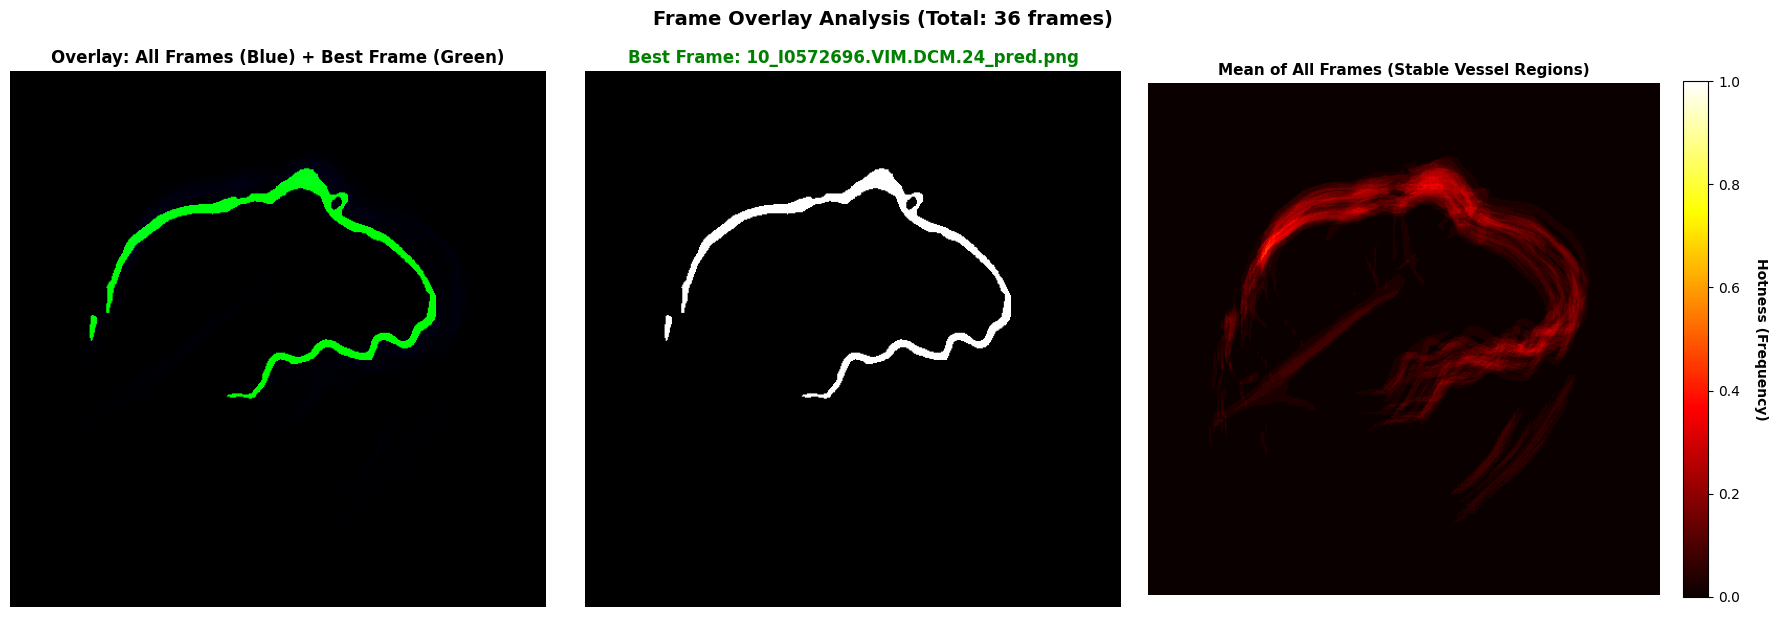

✓ Overlay visualization complete
  - Green: Best frame (#24)
  - Blue: All other frames combined
  - Hot colormap: Average vessel presence across all frames

WIZUALIZACJA OVERLAY KLATEK (z wypełnieniem dziur)


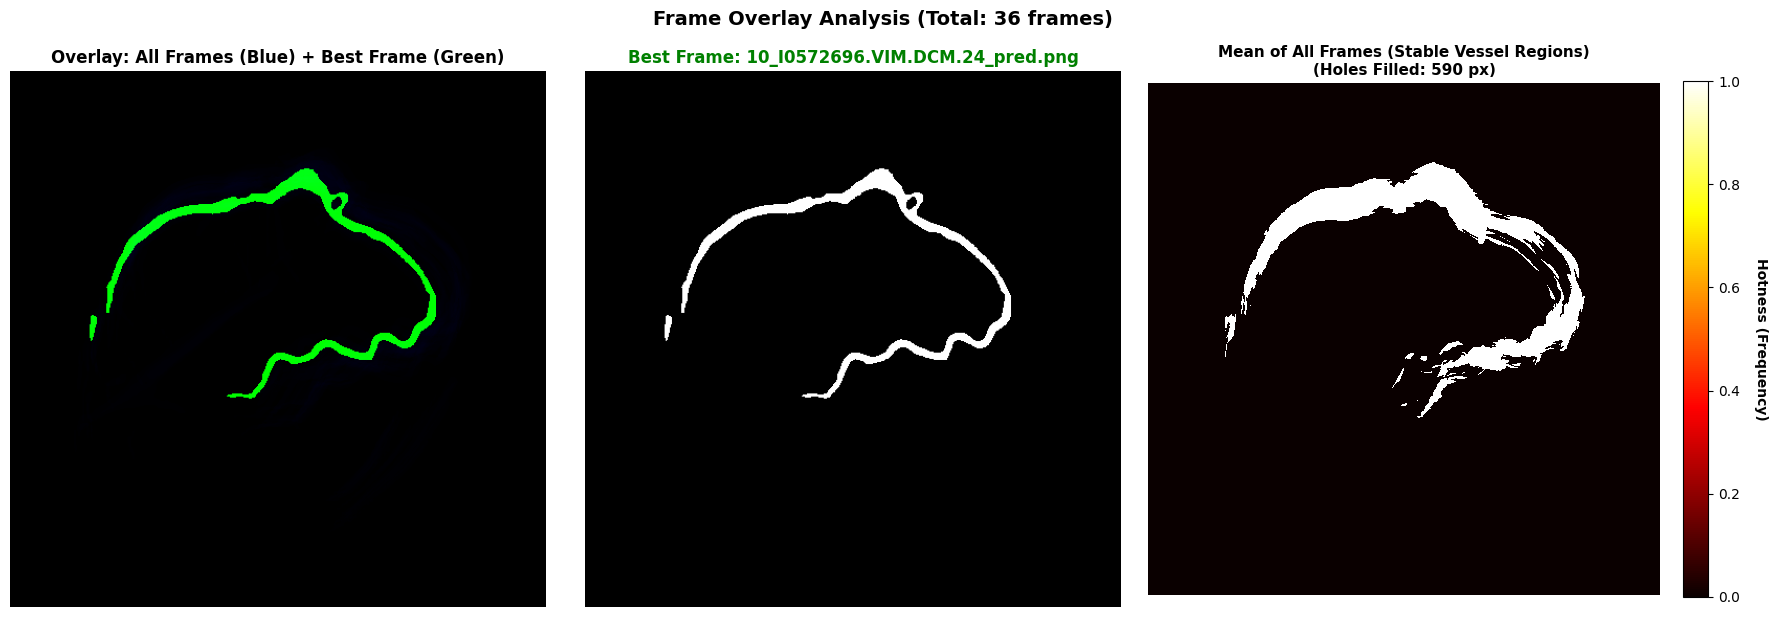

✓ Overlay visualization complete
  - Green: Best frame (#24)
  - Blue: All other frames combined
  - Hot colormap: Average vessel presence across all frames
  - Holes filled: 590 pixels

WIZUALIZACJA OVERLAY KLATEK (hotness ≥ 0.1 + dziury wypełnione)


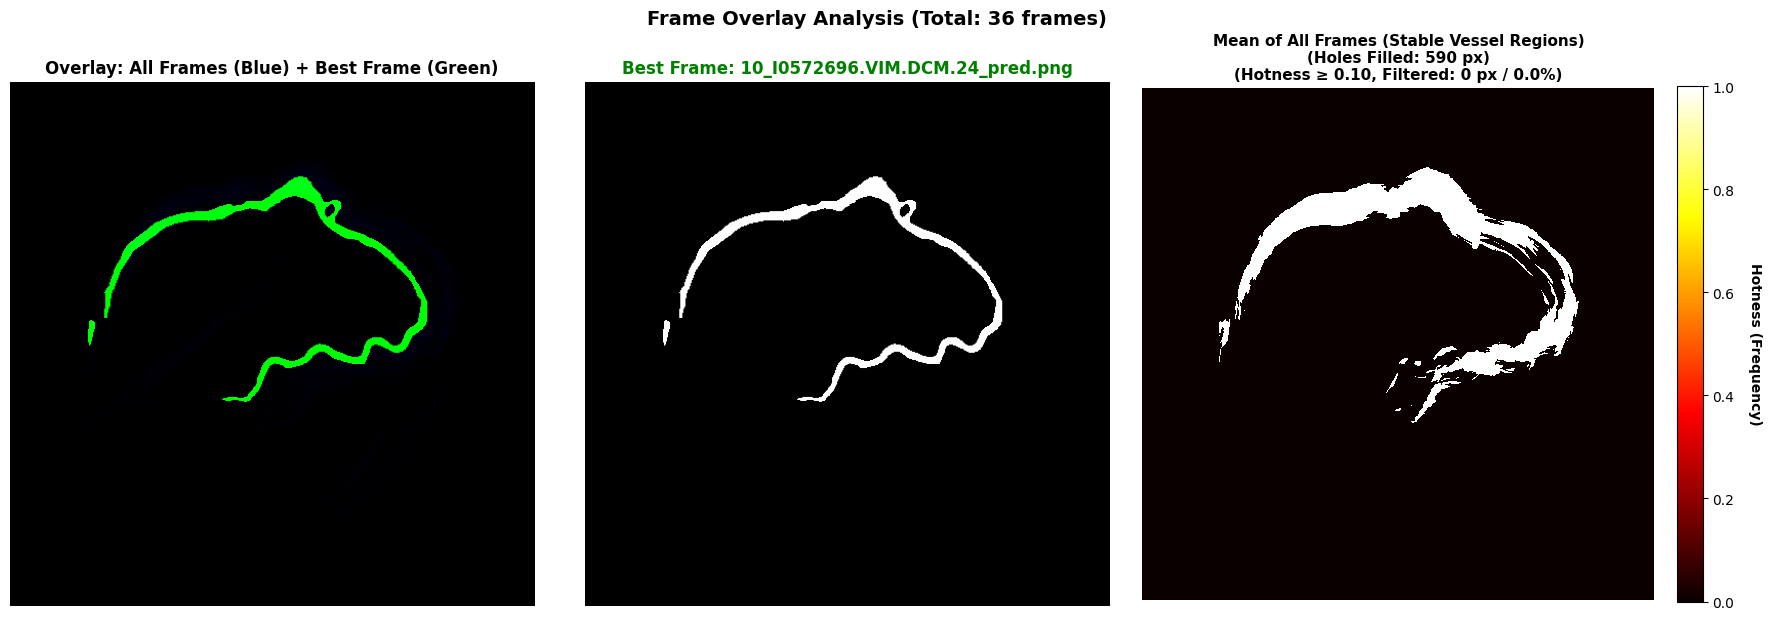

✓ Overlay visualization complete
  - Green: Best frame (#24)
  - Blue: All other frames combined
  - Hot colormap: Average vessel presence across all frames
  - Holes filled: 590 pixels
  - Hotness threshold: 0.10 (filtered 0 pixels, 0.0%)
  - Showing only regions present in ≥10% of frames

WIZUALIZACJA OVERLAY KLATEK (hotness ≥ 0.5 + dziury wypełnione)


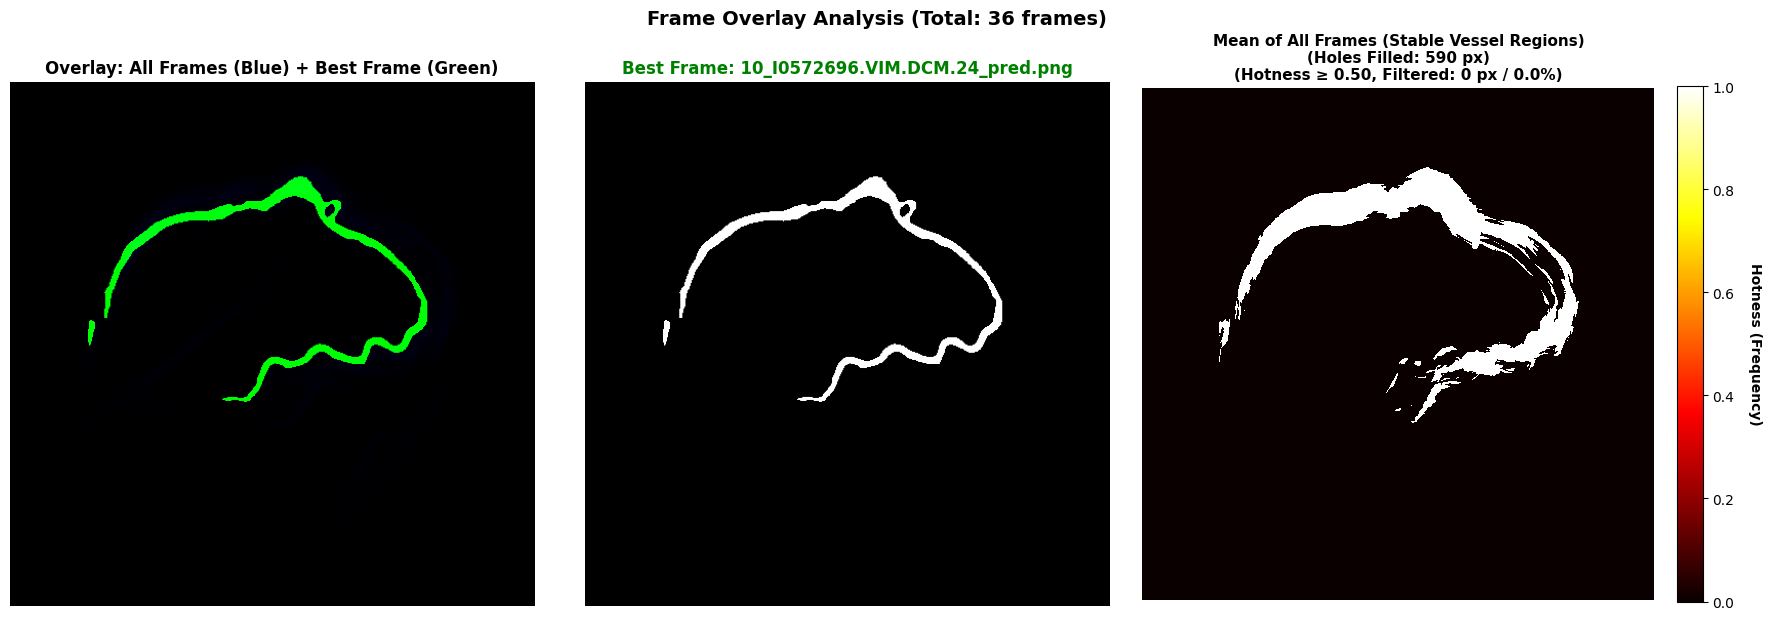

✓ Overlay visualization complete
  - Green: Best frame (#24)
  - Blue: All other frames combined
  - Hot colormap: Average vessel presence across all frames
  - Holes filled: 590 pixels
  - Hotness threshold: 0.50 (filtered 0 pixels, 0.0%)
  - Showing only regions present in ≥50% of frames

WIZUALIZACJA SIATKI WSZYSTKICH KLATEK


/tmp/ipykernel_156236/1188536507.py:481: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


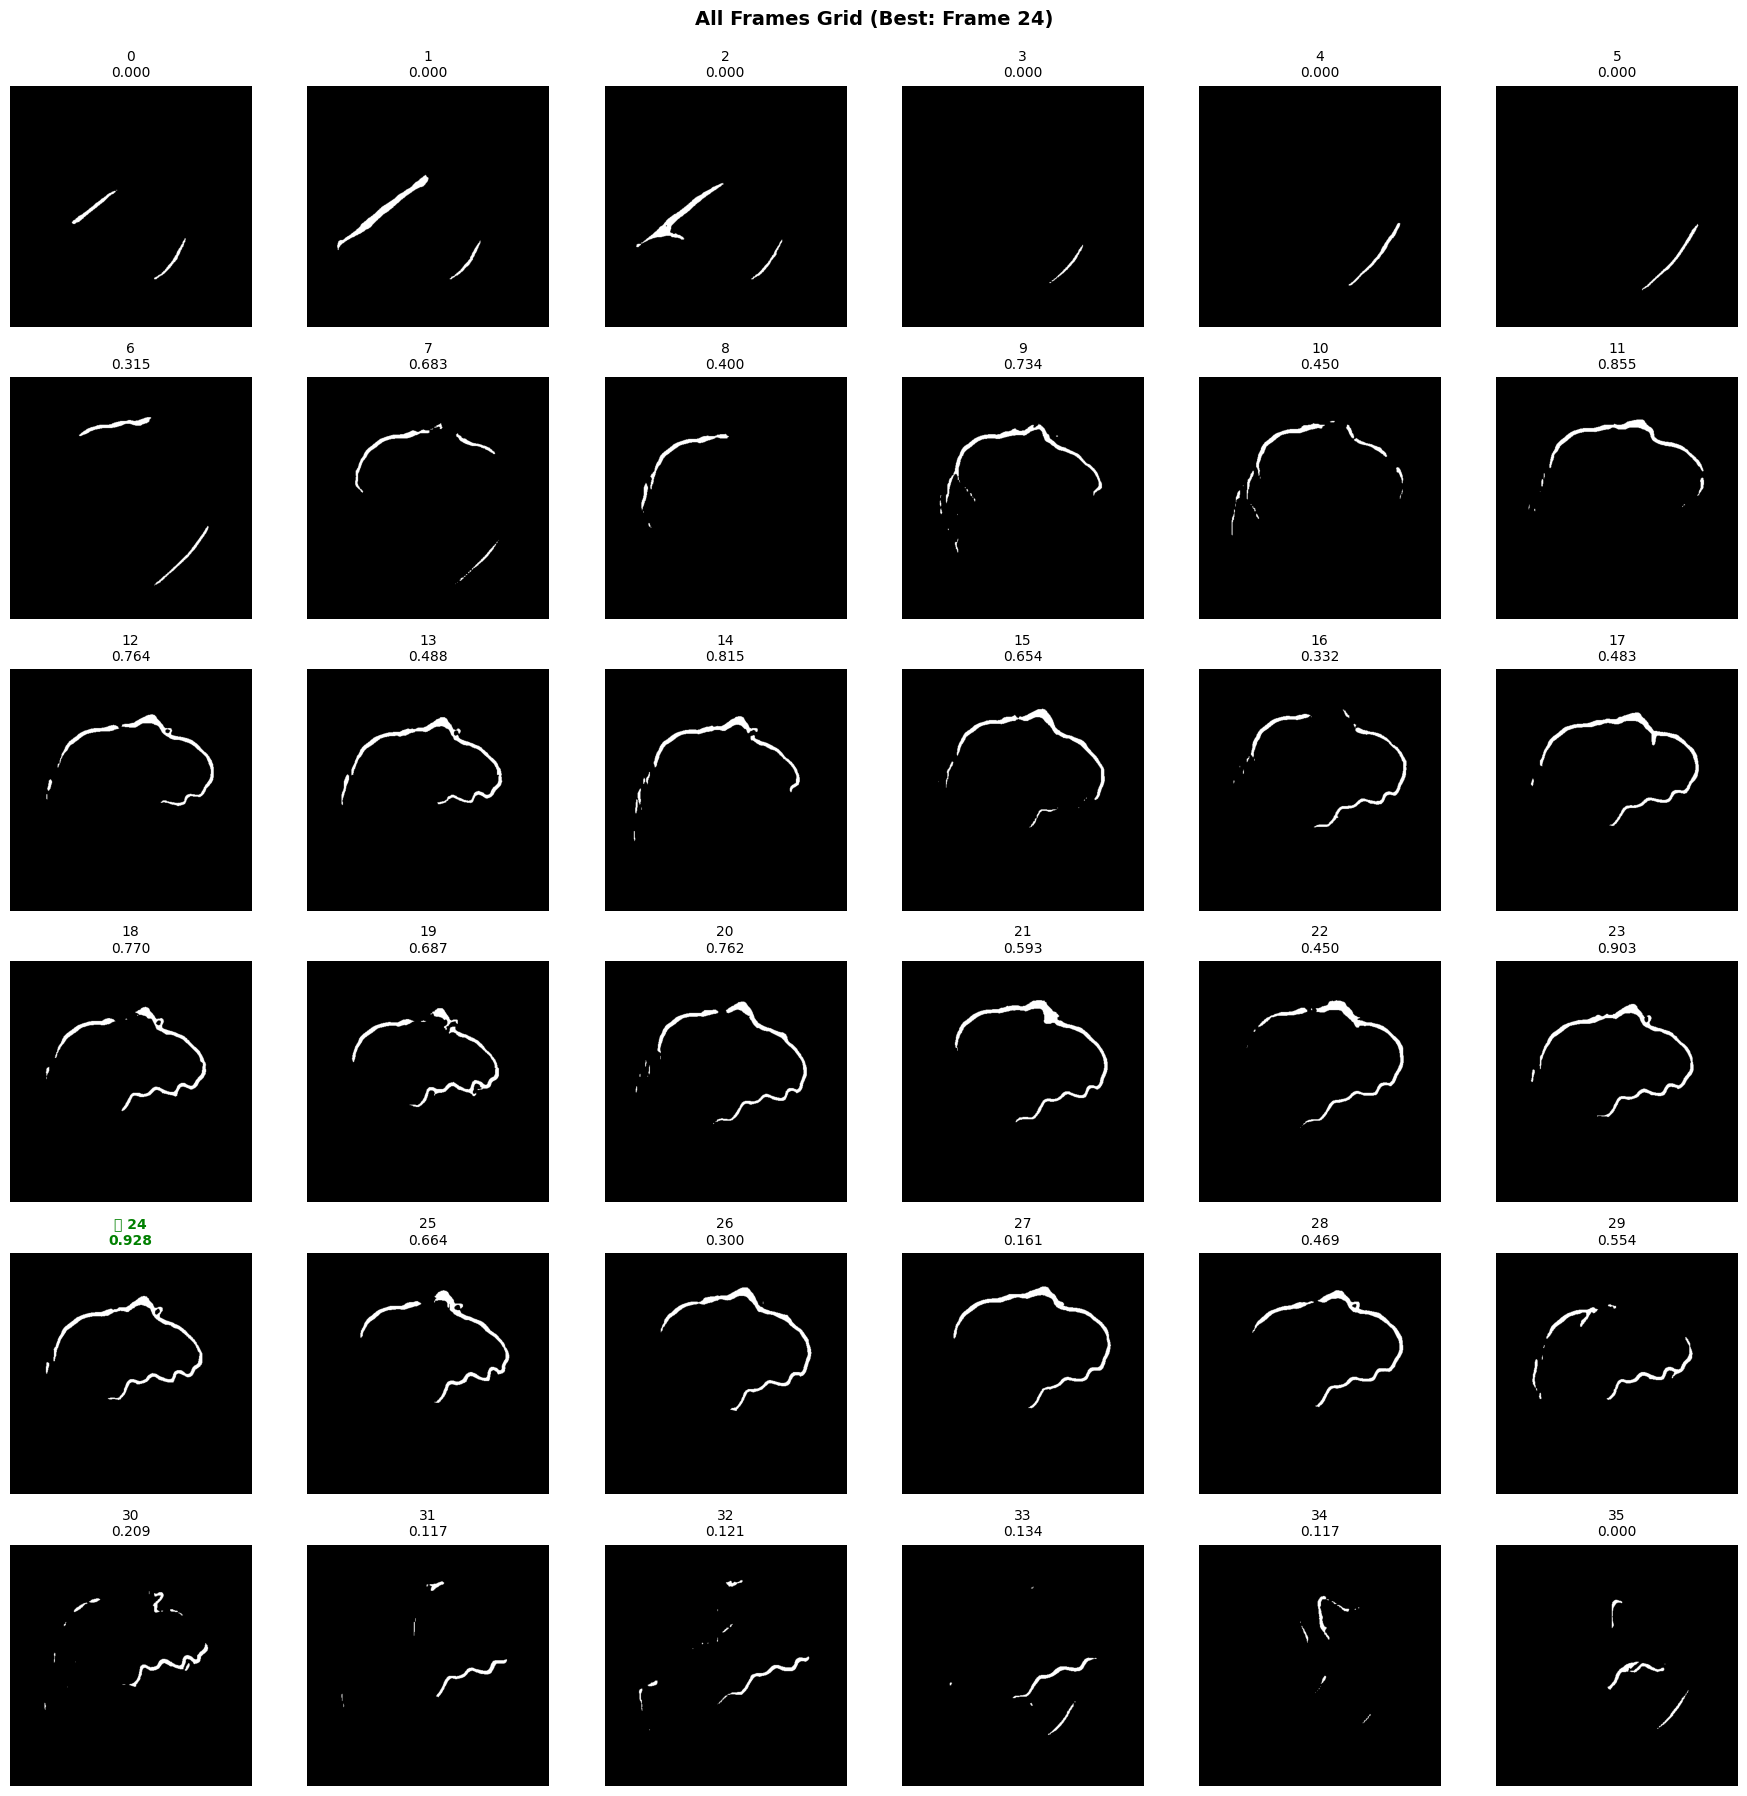

✓ Grid visualization complete with 36 frames

ANALIZA NAKŁADANIA SIĘ WSZYSTKICH KLATEK ZE SOBĄ NAWZAJEM (PAIRWISE)
Obliczanie metryk dla 630 par klatek...
✓ Obliczono metryki dla wszystkich par klatek
✓ Obliczono metryki dla wszystkich par klatek


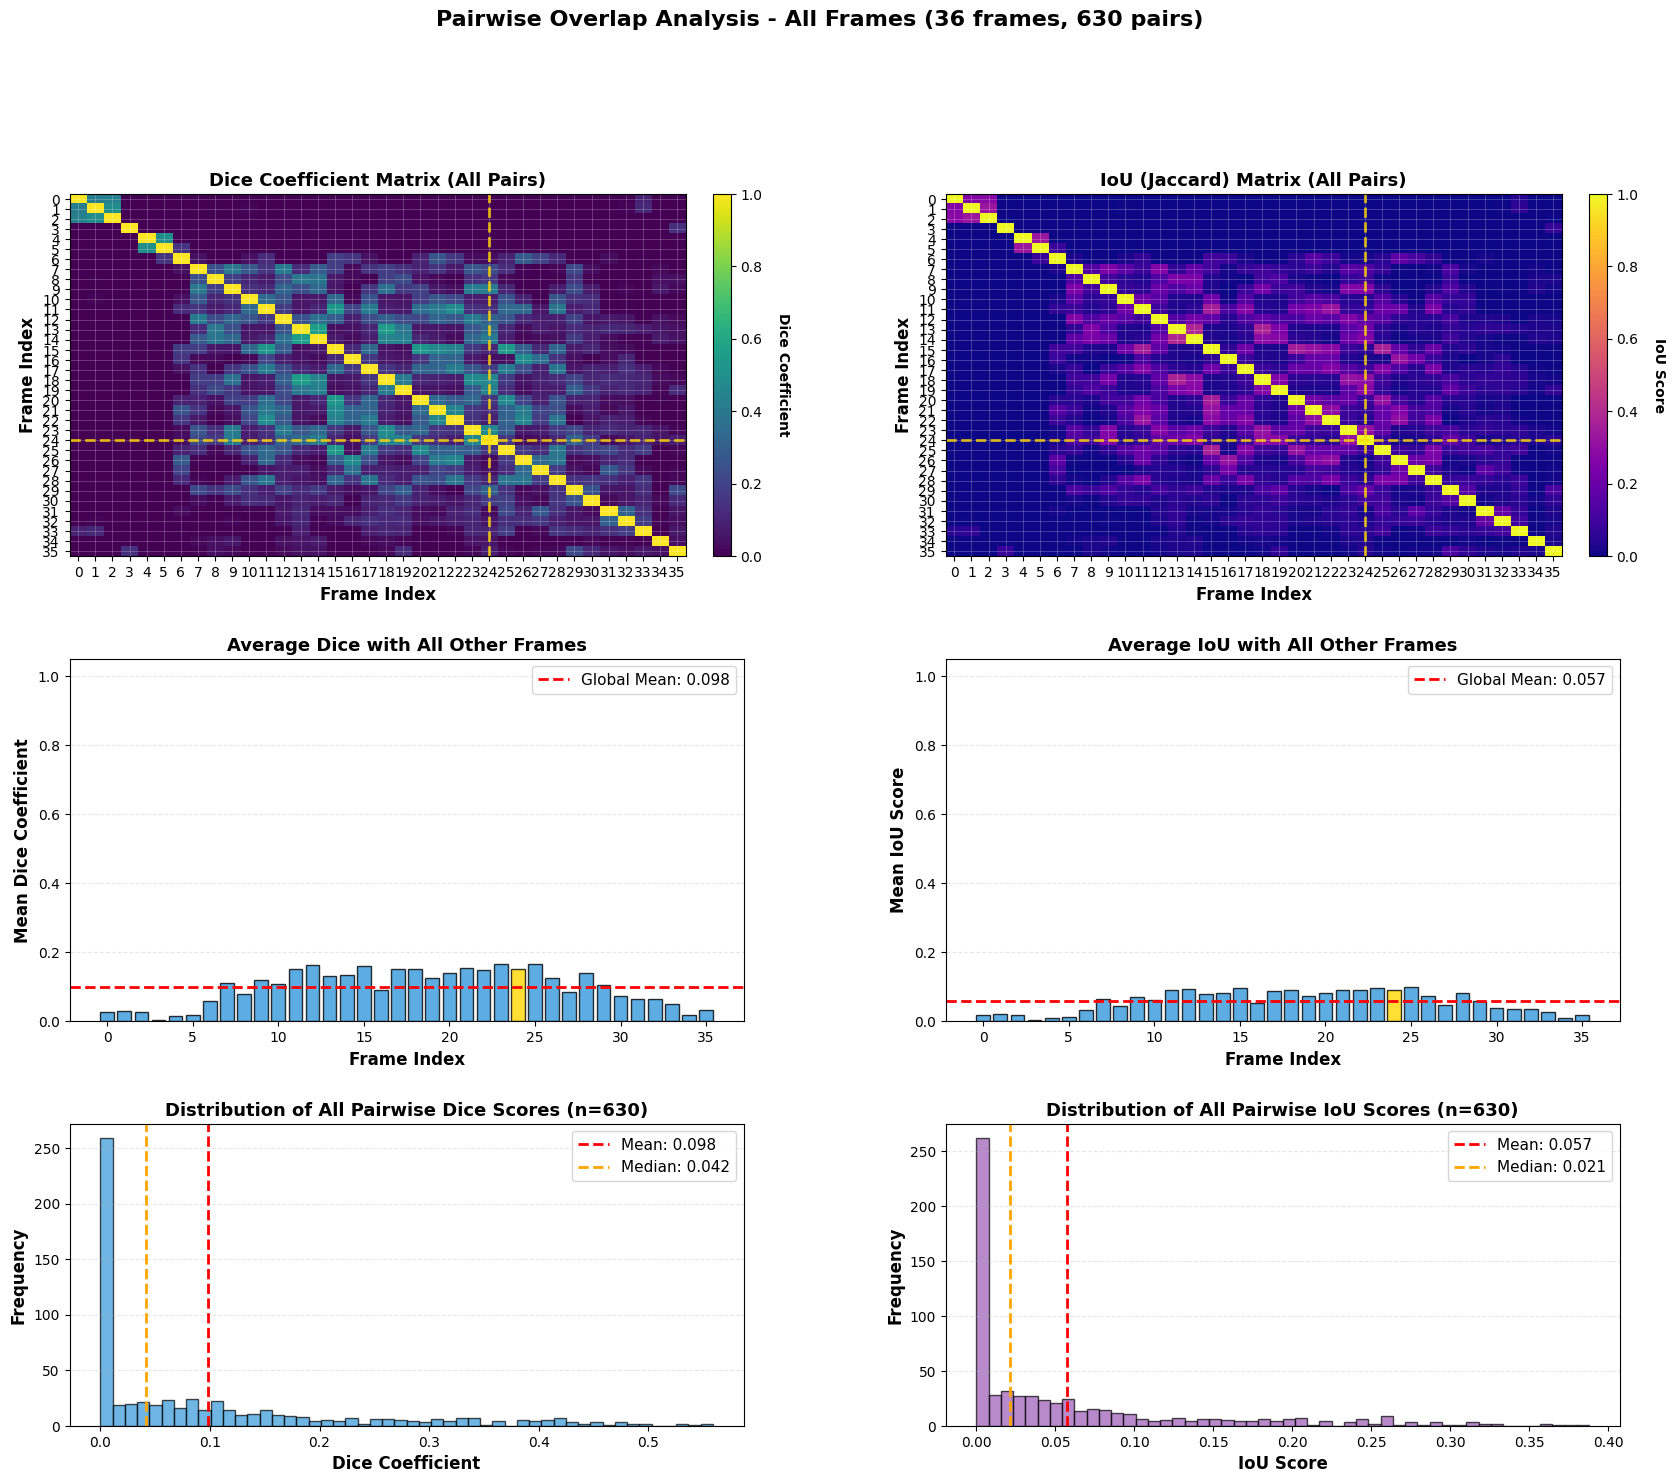


PAIRWISE OVERLAP ANALYSIS - ALL FRAMES
Total frames: 36
Total pairs analyzed: 630

                      --- Dice Coefficient Statistics ---                       
Global mean (all pairs):     0.0980 ± 0.1308
Global median (all pairs):   0.0417
Global min (all pairs):      0.0000
Global max (all pairs):      0.5588

                        --- IoU (Jaccard) Statistics ---                        
Global mean (all pairs):     0.0571 ± 0.0819
Global median (all pairs):   0.0213
Global min (all pairs):      0.0000
Global max (all pairs):      0.3878

                         --- Per-Frame Mean Overlap ---                         
Frame with highest mean Dice: #25 (Dice: 0.1655)
Frame with lowest mean Dice:  #3 (Dice: 0.0040)
Frame with highest mean IoU:  #25 (IoU: 0.0975)
Frame with lowest mean IoU:   #3 (IoU: 0.0021)

                          --- Best Frame Analysis ---                           
Best frame index: #24
Best frame name: 10_I0572696.VIM.DCM.24_pred.png
Best frame mean Dice

In [31]:
def compute_overlap_metrics(mask1, mask2):
    """
    Oblicza metryki nakładania się dwóch masek binarnych
    
    Parameters:
    -----------
    mask1, mask2 : numpy arrays
        Maski binarne do porównania
        
    Returns:
    --------
    dict : Słownik z metrykami (dice, iou, intersection, union)
    """
    # Konwertuj do bool dla pewności
    mask1_bool = mask1.astype(bool)
    mask2_bool = mask2.astype(bool)
    
    # Intersection i Union
    intersection = np.sum(mask1_bool & mask2_bool)
    union = np.sum(mask1_bool | mask2_bool)
    
    # Sum of areas
    area1 = np.sum(mask1_bool)
    area2 = np.sum(mask2_bool)
    
    # IoU (Intersection over Union / Jaccard Index)
    iou = intersection / union if union > 0 else 0.0
    
    # Dice Coefficient (F1 Score / Sørensen–Dice)
    dice = (2 * intersection) / (area1 + area2) if (area1 + area2) > 0 else 0.0
    
    return {
        'dice': dice,
        'iou': iou,
        'intersection': intersection,
        'union': union,
        'area1': area1,
        'area2': area2
    }


def analyze_all_frames_overlap(masks, frame_names=None):
    """
    Analizuje nakładanie się wszystkich klatek ze sobą nawzajem (pairwise)
    
    Parameters:
    -----------
    masks : list of numpy arrays
        Lista masek binarnych
    frame_names : list of str, optional
        Nazwy plików dla każdej klatki
        
    Returns:
    --------
    dict : Słownik zawierający:
        - 'pairwise_metrics': lista słowników z metrykami dla każdej pary klatek
        - 'dice_matrix': macierz Dice coefficients (n_frames x n_frames)
        - 'iou_matrix': macierz IoU scores (n_frames x n_frames)
        - 'mean_dice_per_frame': średni Dice dla każdej klatki z pozostałymi
        - 'mean_iou_per_frame': średni IoU dla każdej klatki z pozostałymi
    """
    n_frames = len(masks)
    
    # Inicjalizuj macierze
    dice_matrix = np.zeros((n_frames, n_frames))
    iou_matrix = np.zeros((n_frames, n_frames))
    
    pairwise_metrics = []
    
    print(f"Obliczanie metryk dla {n_frames * (n_frames - 1) // 2} par klatek...")
    
    # Oblicz metryki dla wszystkich par
    for i in range(n_frames):
        for j in range(i, n_frames):
            if i == j:
                # Porównanie klatki ze sobą samą = 1.0
                dice_matrix[i, j] = 1.0
                iou_matrix[i, j] = 1.0
            else:
                # Oblicz metryki dla pary (i, j)
                metrics = compute_overlap_metrics(masks[i], masks[j])
                
                # Zapisz do macierzy (symetrycznie)
                dice_matrix[i, j] = metrics['dice']
                dice_matrix[j, i] = metrics['dice']
                iou_matrix[i, j] = metrics['iou']
                iou_matrix[j, i] = metrics['iou']
                
                # Zapisz szczegółowe informacje o parze
                pair_info = {
                    'frame_i': i,
                    'frame_j': j,
                    'name_i': frame_names[i] if frame_names and i < len(frame_names) else f"Frame_{i}",
                    'name_j': frame_names[j] if frame_names and j < len(frame_names) else f"Frame_{j}",
                    'dice': metrics['dice'],
                    'iou': metrics['iou'],
                    'intersection': metrics['intersection'],
                    'union': metrics['union']
                }
                pairwise_metrics.append(pair_info)
    
    # Oblicz średnie metryki dla każdej klatki (średnia z porównań z wszystkimi innymi klatkami)
    mean_dice_per_frame = []
    mean_iou_per_frame = []
    
    for i in range(n_frames):
        # Weź wszystkie wartości z macierzy dla klatki i, oprócz porównania ze sobą
        other_frames_mask = np.ones(n_frames, dtype=bool)
        other_frames_mask[i] = False
        
        mean_dice = np.mean(dice_matrix[i, other_frames_mask])
        mean_iou = np.mean(iou_matrix[i, other_frames_mask])
        
        mean_dice_per_frame.append(mean_dice)
        mean_iou_per_frame.append(mean_iou)
    
    print(f"✓ Obliczono metryki dla wszystkich par klatek")
    
    return {
        'pairwise_metrics': pairwise_metrics,
        'dice_matrix': dice_matrix,
        'iou_matrix': iou_matrix,
        'mean_dice_per_frame': mean_dice_per_frame,
        'mean_iou_per_frame': mean_iou_per_frame,
        'n_frames': n_frames
    }


def visualize_all_frames_overlap_analysis(masks, best_frame_idx=None, frame_names=None):
    """
    Wizualizuje analizę nakładania się wszystkich klatek ze sobą nawzajem
    
    Parameters:
    -----------
    masks : list of numpy arrays
        Lista masek binarnych
    best_frame_idx : int, optional
        Indeks najlepszej klatki (do wyróżnienia na wykresach)
    frame_names : list of str, optional
        Nazwy plików dla każdej klatki
    """
    # Oblicz metryki dla wszystkich par
    overlap_data = analyze_all_frames_overlap(masks, frame_names)
    
    dice_matrix = overlap_data['dice_matrix']
    iou_matrix = overlap_data['iou_matrix']
    mean_dice = overlap_data['mean_dice_per_frame']
    mean_iou = overlap_data['mean_iou_per_frame']
    n_frames = overlap_data['n_frames']
    
    # Stwórz figurę z 6 panelami
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1.2, 1], hspace=0.3, wspace=0.3)
    
    # 1. Heatmapa Dice Coefficient
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(dice_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)
    ax1.set_xlabel('Frame Index', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frame Index', fontsize=12, fontweight='bold')
    ax1.set_title('Dice Coefficient Matrix (All Pairs)', fontsize=13, fontweight='bold')
    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Dice Coefficient', rotation=270, labelpad=20, fontweight='bold')
    
    # Dodaj grid dla lepszej czytelności
    ax1.set_xticks(np.arange(n_frames))
    ax1.set_yticks(np.arange(n_frames))
    ax1.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Wyróżnij best frame jeśli podany
    if best_frame_idx is not None:
        ax1.axhline(y=best_frame_idx, color='#FFD700', linestyle='--', linewidth=2, alpha=0.8)
        ax1.axvline(x=best_frame_idx, color='#FFD700', linestyle='--', linewidth=2, alpha=0.8)
    
    # 2. Heatmapa IoU
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(iou_matrix, cmap='plasma', aspect='auto', vmin=0, vmax=1)
    ax2.set_xlabel('Frame Index', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frame Index', fontsize=12, fontweight='bold')
    ax2.set_title('IoU (Jaccard) Matrix (All Pairs)', fontsize=13, fontweight='bold')
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label('IoU Score', rotation=270, labelpad=20, fontweight='bold')
    
    ax2.set_xticks(np.arange(n_frames))
    ax2.set_yticks(np.arange(n_frames))
    ax2.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.3)
    
    if best_frame_idx is not None:
        ax2.axhline(y=best_frame_idx, color='#FFD700', linestyle='--', linewidth=2, alpha=0.8)
        ax2.axvline(x=best_frame_idx, color='#FFD700', linestyle='--', linewidth=2, alpha=0.8)
    
    # 3. Średni Dice dla każdej klatki
    ax3 = fig.add_subplot(gs[1, 0])
    colors = ['#FFD700' if (best_frame_idx is not None and i == best_frame_idx) else '#3498db' 
              for i in range(n_frames)]
    ax3.bar(range(n_frames), mean_dice, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax3.axhline(y=np.mean(mean_dice), color='red', linestyle='--', linewidth=2, 
                label=f'Global Mean: {np.mean(mean_dice):.3f}')
    ax3.set_xlabel('Frame Index', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Mean Dice Coefficient', fontsize=12, fontweight='bold')
    ax3.set_title('Average Dice with All Other Frames', fontsize=13, fontweight='bold')
    ax3.set_ylim(0, 1.05)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.legend(fontsize=11)
    
    # 4. Średni IoU dla każdej klatki
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.bar(range(n_frames), mean_iou, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax4.axhline(y=np.mean(mean_iou), color='red', linestyle='--', linewidth=2, 
                label=f'Global Mean: {np.mean(mean_iou):.3f}')
    ax4.set_xlabel('Frame Index', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Mean IoU Score', fontsize=12, fontweight='bold')
    ax4.set_title('Average IoU with All Other Frames', fontsize=13, fontweight='bold')
    ax4.set_ylim(0, 1.05)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.legend(fontsize=11)
    
    # 5. Histogram rozkładu Dice
    ax5 = fig.add_subplot(gs[2, 0])
    # Weź tylko górną trójkątną część macierzy (bez przekątnej) żeby uniknąć duplikatów
    dice_values = dice_matrix[np.triu_indices_from(dice_matrix, k=1)]
    ax5.hist(dice_values, bins=50, color='#3498db', alpha=0.7, edgecolor='black', linewidth=1)
    ax5.axvline(x=np.mean(dice_values), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(dice_values):.3f}')
    ax5.axvline(x=np.median(dice_values), color='orange', linestyle='--', linewidth=2, 
                label=f'Median: {np.median(dice_values):.3f}')
    ax5.set_xlabel('Dice Coefficient', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax5.set_title(f'Distribution of All Pairwise Dice Scores (n={len(dice_values)})', 
                 fontsize=13, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3, linestyle='--')
    ax5.legend(fontsize=11)
    
    # 6. Histogram rozkładu IoU
    ax6 = fig.add_subplot(gs[2, 1])
    iou_values = iou_matrix[np.triu_indices_from(iou_matrix, k=1)]
    ax6.hist(iou_values, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=1)
    ax6.axvline(x=np.mean(iou_values), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(iou_values):.3f}')
    ax6.axvline(x=np.median(iou_values), color='orange', linestyle='--', linewidth=2, 
                label=f'Median: {np.median(iou_values):.3f}')
    ax6.set_xlabel('IoU Score', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax6.set_title(f'Distribution of All Pairwise IoU Scores (n={len(iou_values)})', 
                 fontsize=13, fontweight='bold')
    ax6.grid(axis='y', alpha=0.3, linestyle='--')
    ax6.legend(fontsize=11)
    
    plt.suptitle(f'Pairwise Overlap Analysis - All Frames ({n_frames} frames, {len(dice_values)} pairs)', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.show()
    
    # Wydrukuj szczegółowe statystyki
    print(f"\n{'='*80}")
    print(f"PAIRWISE OVERLAP ANALYSIS - ALL FRAMES")
    print(f"{'='*80}")
    print(f"Total frames: {n_frames}")
    print(f"Total pairs analyzed: {len(dice_values)}")
    
    print(f"\n{'--- Dice Coefficient Statistics ---':^80}")
    print(f"Global mean (all pairs):     {np.mean(dice_values):.4f} ± {np.std(dice_values):.4f}")
    print(f"Global median (all pairs):   {np.median(dice_values):.4f}")
    print(f"Global min (all pairs):      {np.min(dice_values):.4f}")
    print(f"Global max (all pairs):      {np.max(dice_values):.4f}")
    
    print(f"\n{'--- IoU (Jaccard) Statistics ---':^80}")
    print(f"Global mean (all pairs):     {np.mean(iou_values):.4f} ± {np.std(iou_values):.4f}")
    print(f"Global median (all pairs):   {np.median(iou_values):.4f}")
    print(f"Global min (all pairs):      {np.min(iou_values):.4f}")
    print(f"Global max (all pairs):      {np.max(iou_values):.4f}")
    
    print(f"\n{'--- Per-Frame Mean Overlap ---':^80}")
    print(f"Frame with highest mean Dice: #{np.argmax(mean_dice)} (Dice: {np.max(mean_dice):.4f})")
    print(f"Frame with lowest mean Dice:  #{np.argmin(mean_dice)} (Dice: {np.min(mean_dice):.4f})")
    print(f"Frame with highest mean IoU:  #{np.argmax(mean_iou)} (IoU: {np.max(mean_iou):.4f})")
    print(f"Frame with lowest mean IoU:   #{np.argmin(mean_iou)} (IoU: {np.min(mean_iou):.4f})")
    
    if best_frame_idx is not None:
        print(f"\n{'--- Best Frame Analysis ---':^80}")
        print(f"Best frame index: #{best_frame_idx}")
        if frame_names and best_frame_idx < len(frame_names):
            print(f"Best frame name: {frame_names[best_frame_idx]}")
        print(f"Best frame mean Dice with others: {mean_dice[best_frame_idx]:.4f}")
        print(f"Best frame mean IoU with others:  {mean_iou[best_frame_idx]:.4f}")
    
    # Znajdź najbardziej podobne i najbardziej różne pary
    min_idx = np.unravel_index(np.argmin(dice_matrix + np.eye(n_frames) * 10), dice_matrix.shape)
    max_idx_flat = np.argmax(dice_values)
    triu_indices = np.triu_indices_from(dice_matrix, k=1)
    max_idx = (triu_indices[0][max_idx_flat], triu_indices[1][max_idx_flat])
    
    print(f"\n{'--- Most Similar Pair ---':^80}")
    print(f"Frames {max_idx[0]} & {max_idx[1]}: Dice = {dice_matrix[max_idx]:.4f}, IoU = {iou_matrix[max_idx]:.4f}")
    
    print(f"\n{'--- Most Different Pair ---':^80}")
    print(f"Frames {min_idx[0]} & {min_idx[1]}: Dice = {dice_matrix[min_idx]:.4f}, IoU = {iou_matrix[min_idx]:.4f}")
    
    print(f"{'='*80}\n")
    
    return overlap_data


def visualize_frame_overlay(masks, best_frame_idx, frame_names=None, hotness_threshold=0.0, fill_holes=False):
    """
    Wizualizacja overlay wszystkich klatek z wyróżnieniem najlepszej
    
    Parameters:
    -----------
    masks : list of numpy arrays
        Lista masek binarnych
    best_frame_idx : int
        Indeks najlepszej klatki
    frame_names : list of str, optional
        Nazwy plików dla każdej klatki
    hotness_threshold : float (0.0 - 1.0)
        Minimalny próg jasności/hotness do wyświetlenia w heatmap (0.0 = wszystko, 1.0 = tylko najjaśniejsze)
    fill_holes : bool
        Czy wypełnić dziury w mean mask przed wyświetleniem
    """
    n_frames = len(masks)
    img_shape = masks[0].shape
    
    # Stwórz overlay RGB
    overlay = np.zeros((*img_shape, 3), dtype=np.float32)
    
    # Wszystkie klatki w kolorze niebieskim (z różną intensywnością)
    for i, mask in enumerate(masks):
        if i != best_frame_idx:
            # Niebieskie klatki z niską intensywnością
            overlay[:, :, 2] += mask * 0.3 / (n_frames - 1)
    
    # Najlepsza klatka w kolorze zielonym (mocna intensywność)
    overlay[:, :, 1] += masks[best_frame_idx] * 1.0
    
    # Clip wartości do [0, 1]
    overlay = np.clip(overlay, 0, 1)
    
    # Oblicz średnią wszystkich klatek
    mean_mask = np.mean([m.astype(float) for m in masks], axis=0)
    
    # Wypełnij dziury jeśli requested
    holes_filled_count = 0
    if fill_holes:
        # Krok 1: Binaryzacja mean mask
        binary_mean = (mean_mask > 0.1).astype(np.uint8)
        
        # Krok 2: Wypełnij dziury w binarnej masce
        filled_binary = ndimage.binary_fill_holes(binary_mean).astype(np.uint8)
        
        # Policz ile pikseli zostało wypełnionych
        holes_filled_count = np.sum(filled_binary) - np.sum(binary_mean)
        
        # Użyj wypełnionej binarnej maski jako nowej mean_mask (0 lub 1)
        mean_mask = filled_binary.astype(float)
    
    # Filtruj według hotness (jasności)
    if hotness_threshold > 0.0:
        # Zastosuj threshold bezpośrednio na wartościach mean_mask
        filtered_mask = np.where(mean_mask >= hotness_threshold, mean_mask, 0)
        
        # Policz ile pikseli zostało odfiltrowanych
        total_nonzero = np.sum(mean_mask > 0)
        remaining_pixels = np.sum(filtered_mask > 0)
        removed_pixels = total_nonzero - remaining_pixels
        removed_percentage = (removed_pixels / total_nonzero * 100) if total_nonzero > 0 else 0
        
        mean_mask_display = filtered_mask
        title_suffix = f'\n(Hotness ≥ {hotness_threshold:.2f}, Filtered: {removed_pixels} px / {removed_percentage:.1f}%)'
    else:
        mean_mask_display = mean_mask
        title_suffix = ''
    
    # Dodaj info o wypełnieniu dziur do tytułu
    if fill_holes:
        title_suffix = f'\n(Holes Filled: {holes_filled_count} px)' + title_suffix
    
    # Wizualizacja
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Overlay wszystkich klatek
    axes[0].imshow(overlay)
    axes[0].set_title('Overlay: All Frames (Blue) + Best Frame (Green)', 
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # 2. Najlepsza klatka osobno
    axes[1].imshow(masks[best_frame_idx], cmap='gray')
    best_frame_name = frame_names[best_frame_idx] if frame_names and best_frame_idx < len(frame_names) else f"Frame {best_frame_idx}"
    axes[1].set_title(f'Best Frame: {best_frame_name}', 
                     fontsize=12, fontweight='bold', color='green')
    axes[1].axis('off')
    
    # 3. Średnia wszystkich klatek z filtracją hotness (pokazuje stabilne regiony)
    im = axes[2].imshow(mean_mask_display, cmap='hot', vmin=0, vmax=1)
    axes[2].set_title(f'Mean of All Frames (Stable Vessel Regions){title_suffix}', 
                     fontsize=11, fontweight='bold')
    axes[2].axis('off')
    
    # Dodaj colorbar
    cbar = plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_label('Hotness (Frequency)', rotation=270, labelpad=20, fontweight='bold')
    
    plt.suptitle(f'Frame Overlay Analysis (Total: {n_frames} frames)', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Overlay visualization complete")
    print(f"  - Green: Best frame (#{best_frame_idx})")
    print(f"  - Blue: All other frames combined")
    print(f"  - Hot colormap: Average vessel presence across all frames")
    if fill_holes:
        print(f"  - Holes filled: {holes_filled_count} pixels")
    if hotness_threshold > 0.0:
        print(f"  - Hotness threshold: {hotness_threshold:.2f} (filtered {removed_pixels} pixels, {removed_percentage:.1f}%)")
        print(f"  - Showing only regions present in ≥{hotness_threshold*100:.0f}% of frames")


# Funkcja do wizualizacji grid z wszystkimi klatkami
def visualize_all_frames_grid(masks, best_frame_idx, normalized_scores, frame_names=None, max_cols=5):
    """
    Wyświetla wszystkie klatki w siatce z wyróżnieniem najlepszej
    
    Parameters:
    -----------
    masks : list of numpy arrays
        Lista masek binarnych
    best_frame_idx : int
        Indeks najlepszej klatki
    normalized_scores : list of float
        Lista znormalizowanych scores dla każdej klatki
    frame_names : list of str, optional
        Nazwy plików dla każdej klatki
    max_cols : int
        Maksymalna liczba kolumn w siatce
    """
    n_frames = len(masks)
    n_cols = min(max_cols, n_frames)
    n_rows = (n_frames + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_frames):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        # Wyświetl maskę
        ax.imshow(masks[i], cmap='gray')
        
        # Tytuł z numerem klatki i score
        frame_name = frame_names[i] if frame_names and i < len(frame_names) else f"Frame {i}"
        score = normalized_scores[i] if i < len(normalized_scores) else 0
        
        title_color = 'green' if i == best_frame_idx else 'black'
        title_weight = 'bold' if i == best_frame_idx else 'normal'
        title_prefix = '⭐ ' if i == best_frame_idx else ''
        
        ax.set_title(f'{title_prefix}{i}\n{score:.3f}', 
                    fontsize=10, fontweight=title_weight, color=title_color)
        ax.axis('off')
        
        # Ramka dla najlepszej klatki
        if i == best_frame_idx:
            for spine in ax.spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(4)
                spine.set_visible(True)
    
    # Ukryj puste subploty
    for i in range(n_frames, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle(f'All Frames Grid (Best: Frame {best_frame_idx})', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Grid visualization complete with {n_frames} frames")


# Uruchom wizualizację overlay dla loaded_masks
if loaded_masks:
    # Najpierw oblicz wyniki
    selector = CoronaryKeyframeSelector(loaded_masks)
    result = selector.select_best_frame(profile='long_vessels')
    
    best_idx = result['best_frame_idx']
    
    print("\n" + "="*80)
    print("WIZUALIZACJA OVERLAY KLATEK (bez filtracji)")
    print("="*80)
    
    # Overlay visualization bez threshold
    visualize_frame_overlay(loaded_masks, best_idx, loaded_filenames, hotness_threshold=0.0)
    
    print("\n" + "="*80)
    print("WIZUALIZACJA OVERLAY KLATEK (z wypełnieniem dziur)")
    print("="*80)
    
    # Overlay visualization z wypełnionymi dziurami
    visualize_frame_overlay(loaded_masks, best_idx, loaded_filenames, hotness_threshold=0.0, fill_holes=True)
    
    print("\n" + "="*80)
    print("WIZUALIZACJA OVERLAY KLATEK (hotness ≥ 0.1 + dziury wypełnione)")
    print("="*80)
    
    # Overlay visualization z threshold hotness 0.1 i wypełnionymi dziurami
    visualize_frame_overlay(loaded_masks, best_idx, loaded_filenames, hotness_threshold=0.1, fill_holes=True)
    
    print("\n" + "="*80)
    print("WIZUALIZACJA OVERLAY KLATEK (hotness ≥ 0.5 + dziury wypełnione)")
    print("="*80)
    
    # Overlay visualization z threshold hotness 0.5 i wypełnionymi dziurami
    visualize_frame_overlay(loaded_masks, best_idx, loaded_filenames, hotness_threshold=0.5, fill_holes=True)
    
    print("\n" + "="*80)
    print("WIZUALIZACJA SIATKI WSZYSTKICH KLATEK")
    print("="*80)
    
    # Grid visualization
    visualize_all_frames_grid(loaded_masks, best_idx, result['normalized_scores'], 
                             loaded_filenames, max_cols=6)
    
    print("\n" + "="*80)
    print("ANALIZA NAKŁADANIA SIĘ WSZYSTKICH KLATEK ZE SOBĄ NAWZAJEM (PAIRWISE)")
    print("="*80)
    
    # Overlap analysis (Dice & IoU) - all pairs
    overlap_results = visualize_all_frames_overlap_analysis(loaded_masks, best_idx, loaded_filenames)
else:
    print("No masks loaded. Cannot create overlay visualization.")